In [ ]:
#huggingface
!pip install transformers
#SastrawiStemmer/StopwordsRemover
!pip install PySastrawi
 
!pip install -q pyyaml h5py

     |████████████████████████████████| 1.8MB 8.4MB/s 
     |████████████████████████████████| 890kB 35.8MB/s 
     |████████████████████████████████| 2.9MB 49.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=5cd426ef8b6d181e7dbac7b4bbda99cf069f1f213bc9e14dd1aac398ff8028ed
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 215kB 9.0MB/s 


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import Counter
from numpy import interp
import numpy as np
#from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tqdm
import time
#from torch.utils.data import TensorDataset, random_split

from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import Dense, Dropout,Embedding, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D, Flatten, Conv1D, GlobalMaxPooling1D
#from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import roc_curve, auc, confusion_matrix
#from tensorflow.keras.preprocessing import sequence

#import torch

# If there's a GPU available...
#if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
#    device = torch.device("cuda")

#    print('There are %d GPU(s) available.' % torch.cuda.device_count())

#    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
#else:
#    print('No GPU available, using the CPU instead.')
#    device = torch.device("cpu")

In [ ]:
#LOAD DATASET
#training=pd.read_csv('https://raw.githubusercontent.com/ruzcmc/ClickbaitIndo-textclassifier/master/primary-dataset.csv')
#training=pd.read_csv('https://raw.githubusercontent.com/ruzcmc/ClickbaitIndo-textclassifier/master/clickid-main.csv')
trainingagree=pd.read_csv('https://raw.githubusercontent.com/ruzcmc/ClickbaitIndo-textclassifier/master/all_agree.csv')
#pd.options.display.max_colwidth=2000

trainingagree


#label_cols = ['text','label']

,title,label,label_score
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0
4,MPR: Amandemen UUD 1945 Tak Akan Melebar ke Ma...,non-clickbait,0
...,...,...,...
8608,Twice Rilis Teaser MV 'Feel Special' Jelang Co...,clickbait,1
8609,"Asap Karhutla Riau Mulai Merambah Ke Nias, BM...",non-clickbait,0
8610,"Tolak RUU Pertanahan, Ribuan Petani Siap Gelar...",non-clickbait,0
8611,Ada Niat Tambah Momongan Tanpa Ikut Program Ha...,clickbait,1


3316
5297


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


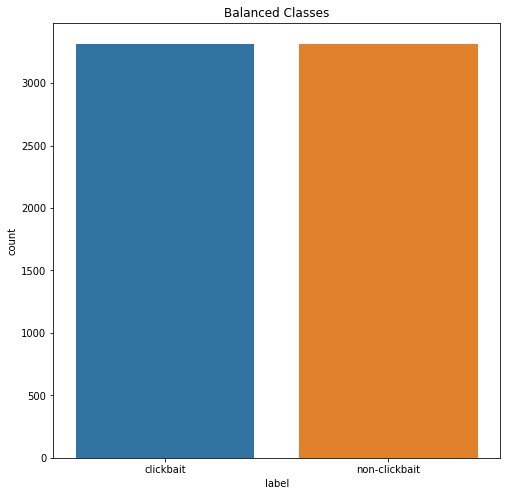

6632


In [ ]:
# UNDERSAMPLE IF NEEDED
#ini yang kappa 1
clickbait = trainingagree.loc[trainingagree['label_score'] == 1]
print(len(clickbait))
nclickbait = trainingagree.loc[trainingagree['label_score'] == 0].sample(n=3316,random_state=22)
nclickbaitasli = trainingagree.loc[trainingagree['label_score'] == 0]
print(len(nclickbaitasli))
# Put all the fraud class in a separate dataset. ini yang kappa 0.4
#clickbait_df = training.loc[training['label_score'] == 1]
#print(len(clickbait_df))
#nclickbait_df = training.loc[training['label_score'] == 0].sample(n=6290,random_state=13)
#print(len(nclickbait_df))

#Randomly select 492 observations from the non-fraud (majority class)
#non_clickbait_df = training.loc[training['label'] == 0].sample(n=1393,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([clickbait, nclickbait])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('label', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

#print(normalized_df)
tags = normalized_df.label_score
texts = normalized_df.title
#print(tags)

#texts
print(len(texts))

In [ ]:
#stemming INDO - no need with BERT TOkenizeR
#factory = StemmerFactory()
#stemmer= factory.create_stemmer()

#textstemss = []
textstem = []
textstemclick = []
textstemnon =[]
#for line in texts:
#  outstem = stemmer.stem(line)
#  textstemss.append(outstem)

#stopword remove
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
for line in clickbait['title']:
  stop = stopword.remove(line)
  textstemclick.append(stop)
for line in nclickbait['title']:
  stopa = stopword.remove(line)
  textstemnon.append(stopa)


for line in texts:
  stop = stopword.remove(line)
  textstem.append(stop)  
  #hapus angka
#from string import digits

#for line in textstems:
#    remove_digits=str.maketrans(' ', ' ', digits)
#    result=line.translate(remove_digits)
#    textstem.append(result)


print(textstem)
#print(texts)

#X_train, X_test, y_train, y_test = train_test_split(textstem, tags, test_size=0.1, random_state=42)
#print(len(X_train))

['Viral! Driver Ojol Bekasi Antar Pesanan Makanan Pakai Sepeda', 'Ada Motor Nyangkut Atas Bambu Sleman, Kok Bisa?', 'Pesan Gamblang Poyuono Menolak Revisi UU KPK', 'Kocak! Maling Rumah Mewah Jakut Terekam CCTV Bingung Cari Jalan Kabur', 'Viral Video Diduga Baku Tembak Sleman, Ini Kata Polisi', 'Waspada! Ada Penipuan Catut Pertamina, Korbannya Rugi Puluhan Juta', 'Jaksa Beberkan Senpi-Peluru Tajam Pembelian Kivlan Zen cs, Ini Rinciannya', 'Sering Quality Time Bersama Keluarga? Ternyata Ini 3 Manfaatnya!', 'Menteri Jokowi 55% Profesional, Ini Kandidatnya?', "Pria Misterius Berjubah Putih Viral Sumut, Ingatkan 'Tuhan Murka'", 'Video Porno Sumedang Disebar Pemeran Pria, Apa Motifnya?', 'Terungkap! Video Porno Sumedang Diperankan Pasangan Selingkuh', 'Kendaraan Listrik Bebas Aturan Ganjil-Genap, Ini Alasannya', 'Menanti "Kebijakan Gila" Jokowi', 'Akhirnya! Pemkot Pekanbaru Liburkan SD SMP Kabut Asap', '2 Ribu Hektare Lahan Terbakar, Udara Palembang Tidak Sehat!', 'Viral Bocah Bekasi Disebut

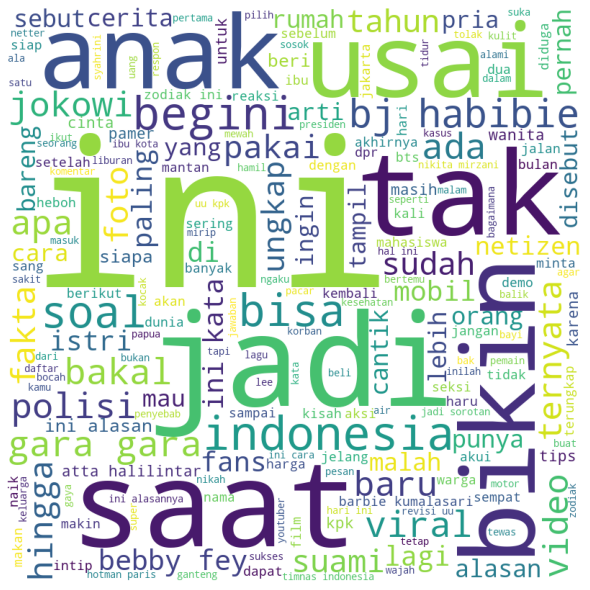

In [ ]:
#descriptive
from wordcloud import WordCloud, STOPWORDS 
comment_words = '' 

#in textstem  
# iterate through the csv file 
for val in textstemclick: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

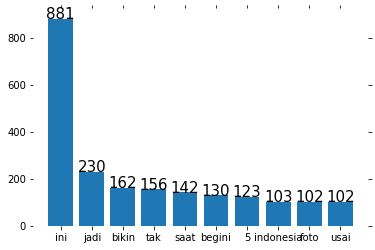

In [ ]:
#descriptive
# Create a list of words by converting to lowercase and splitting
kata = [s.lower().split() for s in textstemclick if s]
noline_ = [sublist for l in kata for sublist in l]
counts1 = dict(Counter(noline_).most_common(10))
labels1, values1 = zip(*counts1.items())

# sort your values in descending order
indSort1 = np.argsort(values1)[::-1]

# rearrange your data
labels1 = np.array(labels1)[indSort1]
values1 = np.array(values1)[indSort1]

indexes1 = np.arange(len(labels1))

bar_width = 1

mybar=plt.bar(indexes1, values1)
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

# plt.show()

# direct label each bar with Y axis values
for bari in mybar:
    height = bari.get_height()
    plt.gca().text(bari.get_x() + bari.get_width()/2, bari.get_height()-0.2, str(int(height)),
                 ha='center', color='black', fontsize=15)
# add labels
plt.xticks(indexes1, labels1)
#plt.savefig('/content/drive/My Drive/clickbait-textclassifier/top10words-NONclickbait.png')
plt.show()


In [ ]:
#TF x huggingface transformers
MAX_LEN = 22
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-lite-base-p1')

def encodetext(sentence):
  input_ids = []
  attention_masks = []
  for sent in sentence:
      
      encoded_dict = tokenizer.encode_plus(
                          sent,                      
                          add_special_tokens = True,      # '[CLS]' and '[SEP]'
                          max_length = MAX_LEN,           
                          pad_to_max_length = True,       # Pad / truncate 
                          return_attention_mask = True,   # Construct attn. masks.
                          
                          return_token_type_ids=False     
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids,attention_masks




In [ ]:
#tags = np.array(tags)
input_ids, attention_masks = np.array(encodetext(textstem))
print('Original: ', textstem[-5])
print('Token IDs:', input_ids[-5])
#print(normalized_df)
print(tags)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Polri-TNI Gelar Apel Pengamanan Jelang Unjuk Rasa DPR
Token IDs: [    2  5487 29947  3463  4263  8441 10958 13619 13689  1214  2441     3
     0     0     0     0     0     0     0     0     0     0]
2       1
8       1
10      1
30      1
37      1
       ..
731     0
2426    0
932     0
248     0
1371    0
Name: label_score, Length: 6632, dtype: int64


In [ ]:
#model definition
#custom model #keras Functional model
def createmodel():
  
 
  token_inputs = Input((MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  mask_inputs = Input((MAX_LEN,), dtype=tf.int32, name='input_masks')
  
  bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-lite-base-p1")
  seq_output = bert_model.bert(input_ids=token_inputs, attention_mask=mask_inputs)[0]
 
  X = GlobalAveragePooling1D()(seq_output)
  X = Flatten()(X)
  X = Dense(100,activation='relu')(X)
  output_= Dense(1, activation='sigmoid', name='output')(X)
 
  bert_model2 = Model([token_inputs,mask_inputs],output_)
  return bert_model2
 
#HF model for Classification
def createhugmodel():
  bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',num_labels=2)
  
  return bert_model

Running Fold 1 / 5


Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFBertModel: ['albert', 'predictions', 'sop_classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
332/332 [==============================] - 36s 67ms/step - loss: 0.5977 - accuracy: 0.6721
Epoch 2/4
332/332 [==============================] - 22s 67ms/step - loss: 0.2908 - accuracy: 0.8844
Epoch 3/4
332/332 [==============================] - 22s 67ms/step - loss: 0.1681 - accuracy: 0.9365
Epoch 4/4
332/332 [==============================] - 22s 67ms/step - loss: 0.1348 - accuracy: 0.9493
Confusion matrix
[[622  41]
 [105 559]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.89       663
           1       0.93      0.84      0.88       664

    accuracy                           0.89      1327
   macro avg       0.89      0.89      0.89      1327
weighted avg       0.89      0.89      0.89      1327

accuracy: 89.00%
AUC
0.890013674607934
Running Fold 2 / 5


Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFBertModel: ['albert', 'predictions', 'sop_classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
332/332 [==============================] - 35s 67ms/step - loss: 0.7267 - accuracy: 0.6113
Epoch 2/4
332/332 [==============================] - 22s 66ms/step - loss: 0.2371 - accuracy: 0.9125
Epoch 3/4
332/332 [==============================] - 22s 67ms/step - loss: 0.1171 - accuracy: 0.9592
Epoch 4/4
332/332 [==============================] - 22s 67ms/step - loss: 0.0665 - accuracy: 0.9774
Confusion matrix
[[617  47]
 [ 82 581]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       664
           1       0.93      0.88      0.90       663

    accuracy                           0.90      1327
   macro avg       0.90      0.90      0.90      1327
weighted avg       0.90      0.90      0.90      1327

accuracy: 90.28%
AUC
0.9027683130712897
Running Fold 3 / 5


Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFBertModel: ['albert', 'predictions', 'sop_classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
332/332 [==============================] - 35s 67ms/step - loss: 0.6953 - accuracy: 0.6076
Epoch 2/4
332/332 [==============================] - 22s 67ms/step - loss: 0.2136 - accuracy: 0.9193
Epoch 3/4
332/332 [==============================] - 22s 67ms/step - loss: 0.1052 - accuracy: 0.9659
Epoch 4/4
332/332 [==============================] - 22s 67ms/step - loss: 0.0742 - accuracy: 0.9757
Confusion matrix
[[570  93]
 [ 53 610]]
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       663
           1       0.87      0.92      0.89       663

    accuracy                           0.89      1326
   macro avg       0.89      0.89      0.89      1326
weighted avg       0.89      0.89      0.89      1326

accuracy: 88.99%
AUC
0.889894419306184
Running Fold 4 / 5


Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFBertModel: ['albert', 'predictions', 'sop_classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
332/332 [==============================] - 35s 67ms/step - loss: 0.7403 - accuracy: 0.6010
Epoch 2/4
332/332 [==============================] - 22s 67ms/step - loss: 0.1929 - accuracy: 0.9185
Epoch 3/4
332/332 [==============================] - 22s 67ms/step - loss: 0.0975 - accuracy: 0.9650
Epoch 4/4
332/332 [==============================] - 22s 67ms/step - loss: 0.0449 - accuracy: 0.9877
Confusion matrix
[[529 134]
 [ 37 626]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       663
           1       0.82      0.94      0.88       663

    accuracy                           0.87      1326
   macro avg       0.88      0.87      0.87      1326
weighted avg       0.88      0.87      0.87      1326

accuracy: 87.10%
AUC
0.8710407239819006
Running Fold 5 / 5


Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFBertModel: ['albert', 'predictions', 'sop_classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
332/332 [==============================] - 36s 67ms/step - loss: 0.6976 - accuracy: 0.6164
Epoch 2/4
332/332 [==============================] - 22s 67ms/step - loss: 0.1893 - accuracy: 0.9274
Epoch 3/4
332/332 [==============================] - 22s 67ms/step - loss: 0.1146 - accuracy: 0.9585
Epoch 4/4
332/332 [==============================] - 22s 67ms/step - loss: 0.0522 - accuracy: 0.9813
Confusion matrix
[[599  64]
 [ 75 588]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       663
           1       0.90      0.89      0.89       663

    accuracy                           0.90      1326
   macro avg       0.90      0.90      0.90      1326
weighted avg       0.90      0.90      0.90      1326

accuracy: 89.52%
AUC
0.8951734539969833


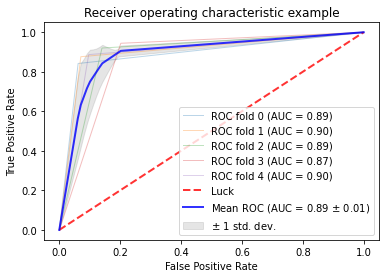

88.98% (+/- 1.05%)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 22)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 22)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109081344   input_word_ids[0][0]             
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           bert[0][0]

In [ ]:
#Kfold CrossVal


from sklearn.metrics import classification_report
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=13)
kfold = kfold.split(input_ids, y=tags)
cvscores = []
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)

i = 0
opt = keras.optimizers.Adam(learning_rate=1e-05)
for i, (train, test) in enumerate(kfold):

  traindata = [input_ids[train],attention_masks[train]]
  testdata = [input_ids[test],attention_masks[test]]
  ytrain = tags.iloc[train]
  ytest = tags.iloc[test]

  
  print("Running Fold", i+1, "/", n_folds)
  
  bert_model2 = createmodel()

  bert_model2.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy'])
  bert_model2.fit(traindata, ytrain, epochs=4,verbose=1,batch_size=16)
  logits = bert_model2.predict(testdata)
  #print(logits) #kalo pake bert layer, ini ga usah tuple langsung aja
  predicts=(logits > 0.5).astype("int32")
  scores = bert_model2.evaluate(testdata, ytest, verbose=0)

  cm = confusion_matrix(ytest, predicts)
  creport = classification_report(ytest, predicts)
  print('Confusion matrix')
  print(cm)
  print(creport)
  print("%s: %.2f%%" % (bert_model2.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
    # Compute ROC curve and area the curve
  fpr, tpr, thresholds = roc_curve(ytest, predicts)
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  print('AUC')
  print(roc_auc)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
  i += 1
  keras.backend.clear_session()

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig('/content/drive/My Drive/clickbait-textclassifier/rocauc-BERT.png')
plt.show()

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

bert_model2.summary()

#print(seq_output)
#model.summary()
# Tell pytorch to run this model on the GPU. i gave up on pytorch this time. sorry
#model.cuda()

In [ ]:
#save Model for Production ^^

xtraining = [input_ids,attention_masks]
ytraining = tags
opt = keras.optimizers.Adam(learning_rate=1e-05)
bert_model2 = createmodel()

bert_model2.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy'])

bert_model2.fit(xtraining, ytraining, epochs=4, verbose=1,batch_size=16)

Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFBertModel: ['albert', 'sop_classifier', 'predictions']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
415/415 [==============================] - 48s 93ms/step - loss: 0.6052 - accuracy: 0.6779
Epoch 2/4
415/415 [==============================] - 40s 96ms/step - loss: 0.2556 - accuracy: 0.8986
Epoch 3/4
415/415 [==============================] - 41s 100ms/step - loss: 0.1797 - accuracy: 0.9301
Epoch 4/4
415/415 [==============================] - 42s 101ms/step - loss: 0.0858 - accuracy: 0.9679


In [ ]:
bert_model2.save("Model.h5", save_format="h5")

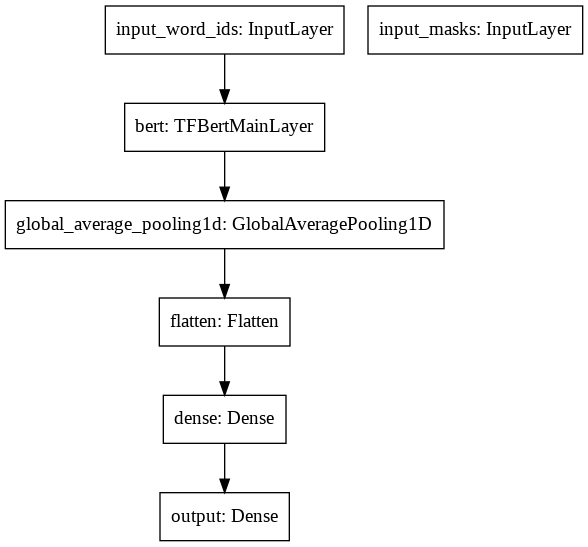

In [ ]:
keras.utils.plot_model(bert_model2)

In [ ]:
#manual testing
manualtest = pd.read_csv('https://raw.githubusercontent.com/ruzcmc/ClickbaitIndo-textclassifier/master/primary-dataset.csv')

#print(manualtest)
#manualtest.head()
manualtests = manualtest.text
tagtest = manualtest.label
#manualtests

In [ ]:
hublah = []

for line in manualtests:
  stop = stopword.remove(line)
  hublah.append(stop)  

In [ ]:
input_ids2, attention_masks2 = np.array(encodetext(hublah))
print('Original: ', manualtests[0])
print('Token IDs:', input_ids2[0])
print('Attn mask:', attention_masks2[0])
testdatamanual = [input_ids2, attention_masks2]

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Purnomo Serahkan Surat Mundur dari Pilkada  ke DPC PDIP Solo
Token IDs: [    2 24322 15475  1387  6969  6478 21052 10639  4412     3     0     0
     0     0     0     0     0     0     0     0     0     0]
Attn mask: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
xtraining = [input_ids,attention_masks]
ytraining = tags
opt = keras.optimizers.Adam(learning_rate=1e-05)
bert_test = createmodel()

bert_test.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy'])
bert_test.fit(xtraining, ytraining, epochs=4,verbose=1,batch_size=16)

Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFBertModel: ['albert', 'predictions', 'sop_classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1 and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
415/415 [==============================] - 40s 67ms/step - loss: 0.6274 - accuracy: 0.6674
Epoch 2/4
415/415 [==============================] - 28s 68ms/step - loss: 0.2792 - accuracy: 0.8881
Epoch 3/4
415/415 [==============================] - 28s 67ms/step - loss: 0.1545 - accuracy: 0.9431
Epoch 4/4
415/415 [==============================] - 28s 67ms/step - loss: 0.0897 - accuracy: 0.9674


0,82 w 5 epochs

0,813 w 3 epochs

In [ ]:
from sklearn.metrics import classification_report

#eval additional test
hasil = bert_model2.predict(testdatamanual)
#print(logits) #kalo pake bert layer, ini ga usah tuple langsung aja
pred=(hasil > 0.5).astype("int32")
scores = bert_model2.evaluate(testdatamanual, tagtest, verbose=0)

cm = confusion_matrix(tagtest, pred)
creport = classification_report(tagtest, pred)
print('Confusion matrix')
print(cm)
print(creport)
print("%s: %.2f%%" % (bert_model2.metrics_names[1], scores[1]*100))
#cvscores.append(scores[1] * 100)
    # Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(tagtest, pred)
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
print('AUC')
print(roc_auc)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC Additional Eval. (AUC = {roc_auc})')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)

#mean_tpr = np.mean(tprs, axis=0)
#mean_tpr[-1] = 1.0
#mean_auc = auc(mean_fpr, mean_tpr)
#std_auc = np.std(aucs)
#plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

#std_tpr = np.std(tprs, axis=0)
#tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig('/content/drive/My Drive/clickbait-textclassifier/rocauc-BERT.png')
plt.show()


Confusion matrix
[[1270  574]
 [ 196 1197]]
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      1844
           1       0.68      0.86      0.76      1393

    accuracy                           0.76      3237
   macro avg       0.77      0.77      0.76      3237
weighted avg       0.78      0.76      0.76      3237

accuracy: 76.21%


NameError: ignored

In [ ]:
bert_test.save("model_name",save_format='tf')


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
T

INFO:tensorflow:Assets written to: model_name/assets


INFO:tensorflow:Assets written to: model_name/assets


In [ ]:
#COBA XGBOOST
def createxg():
  clf = xgb.XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7, verbosity=1, n_estimators=250)
  return clf


In [ ]:
#tfidf vector

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer 
from sklearn.model_selection import cross_val_score
cv=CountVectorizer() 
 
# this steps generates word counts for the words in your docs 
wcvec=cv.fit_transform(textstem)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(wcvec)

countvec = cv.transform(textstem)
tf_idf_vector=tfidf_transformer.transform(countvec)

#print(tf_idf_vector)

xbost = createxg()
#xbost.fit(tf_idf_vector,tags)


scores = cross_val_score(xbost, tf_idf_vector, tags, cv=10, verbose=1)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())


In [ ]:
#berttest.save('/content/drive/My Drive/clickbait-textclassifier/BERT-IndoClickbaitClassifierMODEL.h5')

tf.keras.models.save_model(
    bert_model2,
    "/content/model",
    overwrite=False,
    include_optimizer=True
) 

IndexError: ignored

In [ ]:
model2 = tf.keras.models.load_model("/content/drive/My Drive/clickbait-textclassifier/BERT-IndoClickbaitClassifierMODEL.h5py")